In [1]:
import pandas as pd
import requests
import urllib
import time
import json
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import imdb

def get_data(object_type, username='', subreddit='', search_query='', max_time=None, min_time=1605849200):
    # start from current time if not specified
    if max_time is None:
        max_time = int(time.time())

    # generate filter string
    filter_string = urllib.parse.urlencode(
        {k: v for k, v in zip(
            ['author', 'subreddit', 'q'],
            [username, subreddit, search_query]) if v != ""})

    url_format = "https://api.pushshift.io/reddit/search/{}/?size=500&sort=desc&{}&before={}"

    before = max_time
    df = pd.DataFrame()
    
    while before > min_time :
        url = url_format.format(object_type, filter_string, before)
        resp = requests.get(url)

        # convert records to dataframe
        dfi = pd.json_normalize(json.loads(resp.text)['data'])
        
        if object_type == 'comment':
            dfi = dfi.rename(columns={'created_utc': 'date', 'body': 'comment'})
            df = pd.concat([df, dfi[['id', 'date', 'comment', 'score']]])
        elif object_type == 'submission':
            dfi = dfi.rename(columns={'created_utc': 'date', 'selftext': 'post'})
            dfi = dfi[dfi['post'].ne('')]
            df = pd.concat([df, dfi[['id', 'date', 'post', 'score']]])

        # set `before` to the earliest comment/post in the results
        # next time we call requests.get(...) we will only get comments/posts before
        # the earliest that we already have, thus not fetching any duplicates
        before = dfi['date'].min()

        # if needed
        time.sleep(1)
        
    return df

sent = SentimentIntensityAnalyzer()

[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


In [2]:
username = ""
subreddit = "movies"
sq1 = "Fantastic Beasts: The Secrets of Dumbledore"           # Bad Movie
sq2 = "Father Stu"                          # Bad Movie
sq3 = "The Cellar"                          # Bad Movie
sq4 = "Uncharted"                           # Bad Movie
sq5 = "Morbius"                             # Bad Movie
sq6 = "Spider-Man: No Way Home"             # Good movie
sq7 = "Sonic the Hedgehog 2"                # Good movie
sq8 = "Black Widow"                         # Good movie
sq9 = "CODA"                                # Good movie
sq10 = "The Lost City"                      # Good movie


df1 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq1)
df1['Movie'] = sq1
df1['id'].duplicated().any()    # False
df1['id'].nunique()             # 2200


df2 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq2)
df2['Movie'] = sq2
df2['id'].duplicated().any()    # False
df2['id'].nunique()  


df3 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq3)
df3['Movie'] = sq3
df3['id'].duplicated().any()    # False
df3['id'].nunique() 


df4 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq4)
df4['Movie'] = sq4
df4['id'].duplicated().any()    # False
df4['id'].nunique() 

4292

In [3]:

df5 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq5)
df5['Movie'] = sq5
df5['id'].duplicated().any()    # False
df5['id'].nunique() 


df6 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq6)
df6['Movie'] = sq6
df6['id'].duplicated().any()    # False
df6['id'].nunique() 


df7 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq7)
df7['Movie'] = sq7
df7['id'].duplicated().any()    # False
df7['id'].nunique() 


300

In [4]:
df8 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq8)
df8['id'].duplicated().any()    # False
df8['id'].nunique() 
df8['Movie'] = sq8



df9 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq9)
df9['Movie'] = sq9
df9['id'].duplicated().any()    # False
df9['id'].nunique() 


df10 = get_data(
    object_type='comment',
    username=username,
    subreddit=subreddit,
    search_query=sq10)
df10['Movie'] = sq10
df10['id'].duplicated().any()    # False
df10['id'].nunique() 

1200

In [5]:
combined = pd.concat( [df1, df2,df3, df4,df5,df6,df7,df8,df9,df10] ,ignore_index=True)

polarity = [round(sent.polarity_scores(i)['compound'], 2) for i in combined['comment']]

combined['sentiment_score'] = polarity

final = combined.groupby('Movie')[['sentiment_score']].median()

final["Total Reviews"] = combined.groupby('Movie')[['comment']].count()

In [6]:
final

,sentiment_score,Total Reviews
Movie,,
Black Widow,0.20,6989
CODA,0.60,2100
Fantastic Beasts: The Secrets of Dumbledore,0.45,243
Father Stu,0.00,61
Morbius,0.00,2897
Sonic the Hedgehog 2,0.00,300
Spider-Man: No Way Home,-0.14,1500
The Cellar,0.00,200
The Lost City,-0.05,1200


In [7]:
# create an instance of the IMDb class
ia = imdb.IMDb()

movieids = [4123432, 14439896, 14550642, 1464335, 5108870, 10872600, 12412888, 3480822, 10366460, 13320622]
title = []
rating = []

for i in movieids:
    title.append(str(ia.get_movie(i)))
    review = []
    review = str(ia.get_movie_critic_reviews(i))
    rating.append(review[24:26])

IMDbDF = pd.DataFrame({
    'Title': title,
    'Movie_ID': [4123432, 14439896, 14550642, 1464335, 5108870, 10872600, 12412888, 3480822, 10366460, 13320622],
    'Rating': rating
    })
IMDbDF = IMDbDF.astype({'Rating':'int'})

IMDbDF

,Title,Movie_ID,Rating
0,Fantastic Beasts: The Secrets of Dumbledore,4123432,47
1,Father Stu,14439896,42
2,The Cellar,14550642,49
3,Uncharted,1464335,45
4,Morbius,5108870,35
5,Spider-Man: No Way Home,10872600,71
6,Sonic the Hedgehog 2,12412888,47
7,Black Widow,3480822,67
8,CODA,10366460,74
9,The Lost City,13320622,60


In [8]:
data_analysis = pd.merge(final, IMDbDF, left_on = 'Movie', right_on ='Title')
data_analysis = data_analysis.set_index('Movie_ID')
data_analysis

,sentiment_score,Total Reviews,Title,Rating
Movie_ID,,,,
3480822,0.20,6989,Black Widow,67
10366460,0.60,2100,CODA,74
4123432,0.45,243,Fantastic Beasts: The Secrets of Dumbledore,47
14439896,0.00,61,Father Stu,42
5108870,0.00,2897,Morbius,35
12412888,0.00,300,Sonic the Hedgehog 2,47
10872600,-0.14,1500,Spider-Man: No Way Home,71
14550642,0.00,200,The Cellar,49
13320622,-0.05,1200,The Lost City,60


In [9]:
# for data visualizations

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

[Text(0, 0, 'Black Widow'),
 Text(1, 0, 'CODA'),
 Text(2, 0, 'Fantastic Beasts: The Secrets of Dumbledore'),
 Text(3, 0, 'Father Stu'),
 Text(4, 0, 'Morbius'),
 Text(5, 0, 'Sonic the Hedgehog 2'),
 Text(6, 0, 'Spider-Man: No Way Home'),
 Text(7, 0, 'The Cellar'),
 Text(8, 0, 'The Lost City'),
 Text(9, 0, 'Uncharted')]

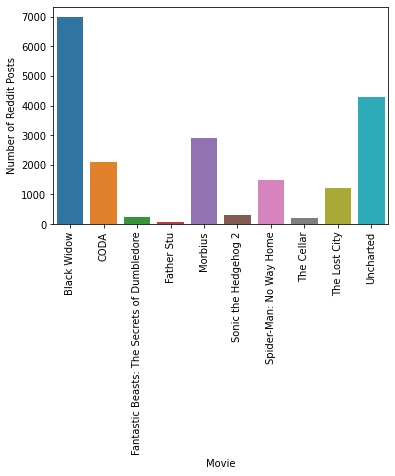

In [10]:
bar = sns.barplot(x='Title', y='Total Reviews', data=data_analysis)
bar.set(xlabel = "Movie", ylabel = "Number of Reddit Posts")
bar.set_xticklabels(bar.get_xticklabels(),rotation = 90)

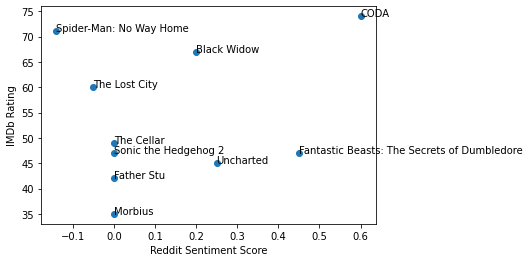

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x='sentiment_score', y='Rating', data=data_analysis)
ax.set(xlabel = "Reddit Sentiment Score", ylabel = "IMDb Rating")

for idx, row in data_analysis.iterrows():
   ax.annotate(row['Title'], (row['sentiment_score'], row['Rating']) )
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9b264167f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9b264161f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9b264165e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9b26410550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9b264106d0>],
 'means': []}

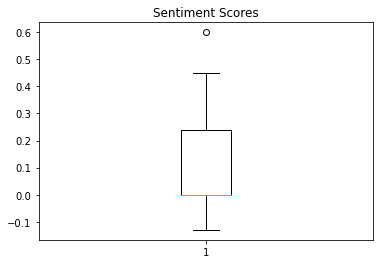

In [ ]:
fig1, ax1 = plt.subplots()
ax1.set_title('Sentiment Scores')
ax1.boxplot(data_analysis['sentiment_score'])